In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv('merged_movies.csv')

### For now use the weighted rating

In [3]:
data = data.drop_duplicates(subset ='tconst')

In [4]:
print(data.shape)
data.columns

(33295, 37)


Index(['tconst', 'primaryTitle', 'originalTitle', 'runtimeMinutes', 'genres_x',
       'averageRating', 'numVotes', 'has_well_known_director',
       'directors_name', 'has_well_known_actors', 'primary_actors', 'id_int',
       'keywords', 'belongs_to_collection', 'budget', 'genres_y', 'homepage',
       'original_language', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'vote_average', 'vote_count',
       'weighted_rating', 'adjusted_budget', 'adjusted_revenue',
       'original_english', 'has_production_companies',
       'is_top_production_company', 'release_month', 'has_tag_line'],
      dtype='object')

### Select cols for model

In [5]:
cols = ['runtimeMinutes', 'averageRating','numVotes','weighted_rating', 'runtime','vote_average','vote_count', # important features
        'genres_x', 'genres_y', 'adjusted_budget', 'adjusted_revenue', 'release_month', # possible predictive features
        'has_well_known_director','has_well_known_actors', 'is_top_production_company', # binary extracted features
        'production_countries','belongs_to_collection','has_tag_line','homepage','spoken_languages','original_english',
        'popularity','keywords','overview','directors_name','primary_actors' # for text
        ]
movie_models = data[cols]

In [6]:
# for now select those with at least 5k votes
movie_models = movie_models[movie_models['numVotes'] > 5000]

In [7]:
remove_for_now_cols = ['runtime','vote_average','vote_count','averageRating','numVotes','genres_x','keywords','overview','primary_actors','directors_name','adjusted_revenue','popularity']
model_cols = [col for col in movie_models.columns if col not in remove_for_now_cols]
movie_models = movie_models[model_cols]

In [8]:
pd.qcut(movie_models['weighted_rating'], 10, duplicates= 'drop').value_counts().sort_index()

(2.81, 6.037]     1242
(6.037, 6.258]    1241
(6.258, 6.386]    1241
(6.386, 6.5]      1612
(6.5, 6.581]       870
(6.581, 6.67]     1241
(6.67, 6.77]      1241
(6.77, 6.935]     1241
(6.935, 7.224]    1241
(7.224, 9.273]    1241
Name: weighted_rating, dtype: int64

7.2 to be considered top 10.

In [9]:
movie_models.isnull().sum()

runtimeMinutes               0
weighted_rating              0
genres_y                     0
adjusted_budget              1
release_month                1
has_well_known_director      0
has_well_known_actors        0
is_top_production_company    0
production_countries         0
belongs_to_collection        0
has_tag_line                 0
homepage                     0
spoken_languages             0
original_english             0
dtype: int64

In [10]:
movie_models.dropna(inplace = True)

In [11]:
# binary weighted rating for now
movie_models['weighted_rating'] = (movie_models['weighted_rating'] > 7).astype(int)

### Preprocessing

#### Convert month into category

In [12]:
import calendar

movie_models['release_month'] = movie_models.release_month.apply(lambda x: calendar.month_name[int(x)])

### Convert columns

In [13]:
movie_models.dtypes

runtimeMinutes               float64
weighted_rating                int32
genres_y                      object
adjusted_budget              float64
release_month                 object
has_well_known_director        int64
has_well_known_actors          int64
is_top_production_company      int64
production_countries           int64
belongs_to_collection          int64
has_tag_line                   int64
homepage                       int64
spoken_languages               int64
original_english               int64
dtype: object

In [14]:
num_cols = ['runtimeMinutes','adjusted_budget','production_countries','spoken_languages']
cat_cols1 = ['genres_y','release_month']
cat_cols2 = ['has_well_known_director','has_well_known_actors','is_top_production_company',
            'belongs_to_collection','has_tag_line','homepage','original_english']

In [15]:
movie_models[cat_cols2] = movie_models[cat_cols2].astype(object)

In [16]:
movie_models.dtypes.sort_values()

weighted_rating                int32
production_countries           int64
spoken_languages               int64
runtimeMinutes               float64
adjusted_budget              float64
genres_y                      object
release_month                 object
has_well_known_director       object
has_well_known_actors         object
is_top_production_company     object
belongs_to_collection         object
has_tag_line                  object
homepage                      object
original_english              object
dtype: object

#### Filter those with budget > 0

In [17]:
movie_models = movie_models[movie_models['adjusted_budget'] > 0]

In [18]:
movie_models.shape

(6189, 14)

#### Dummy variables for genre

In [23]:
import ast
def get_genre(genres_list):
    genres = ast.literal_eval(genres_list)
    return ','.join([genre.strip() for genre in genres])

In [28]:
genres_dummy =  movie_models['genres_y'].apply(get_genre).str.get_dummies(',')
genres_dummy

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
21,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
33,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
86,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33330,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33353,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
33363,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33393,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0


In [29]:
movie_models = pd.concat([movie_models, genres_dummy], axis = 1)

In [32]:
movie_models.drop(columns=['genres_y'], inplace= True)

In [33]:
print(movie_models.shape)
movie_models.head()

(6189, 33)


,runtimeMinutes,weighted_rating,adjusted_budget,release_month,has_well_known_director,has_well_known_actors,is_top_production_company,production_countries,belongs_to_collection,has_tag_line,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
21,195.0,0,2.486208e+06,February,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,1,0
33,163.0,0,1.933927e+08,September,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
62,76.0,1,2.259963e+05,February,0,0,0,1,0,1,...,0,1,0,0,0,0,0,1,0,0
86,68.0,1,3.507081e+06,January,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
101,78.0,0,7.921828e+05,June,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# log of budget
movie_models['adjusted_budget'] = np.log(movie_models['adjusted_budget'])

#### Dummy variables for month

In [25]:
# month_dummies =  movie_models['release_month'].str.get_dummies()
# movie_models = pd.concat([movie_models, month_dummies], 1)
# movie_models.drop(columns=['release_month'], inplace= True)

#### Random shuffling for baseline

In [41]:
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, roc_auc_score, confusion_matrix, log_loss
y = movie_models['weighted_rating'].values
y_shuffle = shuffle(y)


print(classification_report(y_pred= y_shuffle, y_true= y))
print('Logloss', log_loss(y_pred= y_shuffle, y_true= y))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      4750
           1       0.22      0.22      0.22      1439

    accuracy                           0.64      6189
   macro avg       0.49      0.49      0.49      6189
weighted avg       0.64      0.64      0.64      6189

Logloss 12.523171979075173


#### Split data

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(movie_models.drop(columns=['weighted_rating'], axis = 1), movie_models['weighted_rating'], 
                                        stratify= movie_models['weighted_rating'], test_size=.25, random_state=42)

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] =  scaler.transform(X_test[num_cols])

In [44]:
import category_encoders as ce
encoder = ce.TargetEncoder(cols =  ['release_month'] +  cat_cols2 + list(genres_dummy.columns))
X_train_trans = encoder.fit_transform(X_train, y_train)
X_test_trans = encoder.transform(X_test)

# X_train_trans = X_train
# X_test_trans = X_test

In [45]:
print(X_train_trans.shape)
print(X_test_trans.shape)
print(y_train.mean())
print(y_test.mean())

(4641, 32)
(1548, 32)
0.23249299719887956
0.23255813953488372


In [46]:
X_train_trans.head()

,runtimeMinutes,adjusted_budget,release_month,has_well_known_director,has_well_known_actors,is_top_production_company,production_countries,belongs_to_collection,has_tag_line,homepage,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
32647,1.328592,-0.324641,0.235935,0.202145,0.216353,0.272099,-0.486618,0.235653,0.162328,0.208724,...,0.376190,0.252488,0.231577,0.231782,0.236191,0.236907,0.232578,0.197977,0.225843,0.230972
21773,-0.780342,0.038247,0.232104,0.202145,0.216353,0.214532,-0.486618,0.235653,0.162328,0.280078,...,0.225683,0.103060,0.231577,0.231782,0.236191,0.236907,0.232578,0.247160,0.225843,0.230972
25427,-0.209172,-0.773568,0.235935,0.202145,0.216353,0.214532,-0.486618,0.235653,0.243982,0.280078,...,0.225683,0.252488,0.231577,0.231782,0.215733,0.236907,0.232578,0.247160,0.225843,0.230972
21501,-0.956086,0.112470,0.202941,0.202145,0.216353,0.214532,-0.486618,0.221470,0.243982,0.208724,...,0.225683,0.252488,0.231577,0.231782,0.236191,0.236907,0.232578,0.247160,0.225843,0.230972
28456,-0.868214,-0.491424,0.191136,0.202145,0.477352,0.214532,-0.486618,0.235653,0.243982,0.208724,...,0.225683,0.252488,0.231577,0.231782,0.215733,0.236907,0.232578,0.247160,0.225843,0.230972


### Modeling

#### Naive Bayes

Use as baseline metrics along with random shuffle

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1188
           1       0.42      0.46      0.44       360

    accuracy                           0.73      1548
   macro avg       0.63      0.63      0.63      1548
weighted avg       0.74      0.73      0.73      1548

AUC train:0.7297
AUC test :0.745

Logloss 9.482665035168505


<AxesSubplot:>

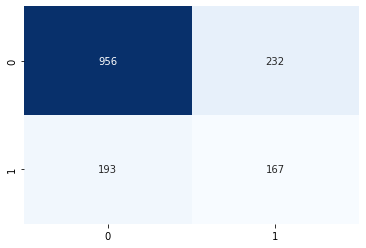

In [47]:
import seaborn as sns
from sklearn.naive_bayes import GaussianNB

NB_clf = GaussianNB()
NB_clf.fit(X_train_trans, y_train)


y_pred  =  NB_clf.predict(X_test_trans)

print(classification_report(y_pred= y_pred, y_true= y_test))

proba_train = NB_clf.predict_proba(X_train_trans)[:,1]
proba_test = NB_clf.predict_proba(X_test_trans)[:,1]

print(f"AUC train:{round(roc_auc_score(y_train, proba_train),4)}")
print(f"AUC test :{round(roc_auc_score(y_test, proba_test),4)}\n")
print('Logloss', log_loss(y_pred= y_pred, y_true= y_test))

cm = confusion_matrix(y_pred= y_pred, y_true= y_test)

sns.heatmap(cm, annot=True, cbar = False, fmt = 'g', cmap ='Blues')


### Random Forest

Identify feature importances.

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

params = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230], 
               'class_weight': ['balanced',{0:1,1:2}, {0:1, 1:3}]}


rf_clf = RandomForestClassifier()
rf_grid = RandomizedSearchCV(estimator = rf_clf, scoring='f1', param_distributions= params, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_grid.fit(X_train_trans, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         {0: 1, 1: 2},
                                                         {0: 1, 1: 3}],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [130, 180, 230]},
                   random_state=42, scoring='f1', verbose=2)

In [49]:
best_rf = rf_grid.best_estimator_
best_rf

RandomForestClassifier(class_weight={0: 1, 1: 3}, max_depth=20,
                       max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=230)

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1188
           1       0.52      0.54      0.53       360

    accuracy                           0.78      1548
   macro avg       0.69      0.70      0.69      1548
weighted avg       0.78      0.78      0.78      1548

AUC train:0.9484
AUC test :0.7934

Logloss 7.675376619758856


<AxesSubplot:>

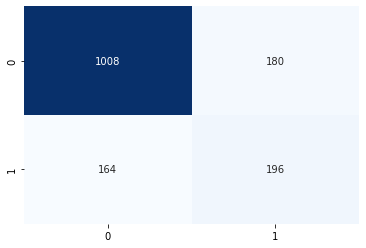

In [50]:
y_pred  =  best_rf.predict(X_test_trans)

print(classification_report(y_pred= y_pred, y_true= y_test))

proba_train = best_rf.predict_proba(X_train_trans)[:,1]
proba_test = best_rf.predict_proba(X_test_trans)[:,1]

print(f"AUC train:{round(roc_auc_score(y_train, proba_train),4)}")
print(f"AUC test :{round(roc_auc_score(y_test, proba_test),4)}\n")
print('Logloss', log_loss(y_pred= y_pred, y_true= y_test))

cm = confusion_matrix(y_pred= y_pred, y_true= y_test)
sns.heatmap(cm, annot=True, cbar = False, fmt = 'g', cmap ='Blues')

In [51]:
importances = pd.Series(best_rf.feature_importances_, index = X_train_trans.columns)
importances.sort_values(ascending = False)[:15]

runtimeMinutes               0.255420
adjusted_budget              0.145324
release_month                0.088939
has_well_known_director      0.075929
Drama                        0.048692
spoken_languages             0.034126
Comedy                       0.028475
production_countries         0.025894
Action                       0.024371
Horror                       0.023797
homepage                     0.023741
is_top_production_company    0.022182
has_tag_line                 0.021732
Thriller                     0.018935
has_well_known_actors        0.018388
dtype: float64